# Helper Notebook for the Second Laboratory

In [59]:
import numpy as np
import random 
import pandas as pd
import pyomo
import pyomo.environ as env
import matplotlib.pyplot as plt
import networkx as nx

from pyomo.environ import *
from pyomo.opt import SolverFactory

# Problem 1: Transportation Problem
# Sensitivity Analysis in Linear Programming

This notebook demonstrates how to perform sensitivity analysis in linear programming using Python. Sensitivity analysis helps you understand how the optimal solution changes with changes in the model's parameters, such as the objective function coefficients and right-hand side values of the constraints.

> **Note:** Sensibility analysis can only be performed on linear programming models.

### Mathematical Formulation:

#### **Decision Variables:**
- $ x \geq 0 $: Represents the quantity of the first product.
- $ y \geq 0 $: Represents the quantity of the second product.

#### **Objective Function:**
The objective is to **maximize** the total profit, which depends on the quantities of products $x$ and $y$:
$$
\text{Maximize: } 40x + 30y
$$
Where:
- The profit per unit of product \(x\) is 40.
- The profit per unit of product \(y\) is 30.

#### **Constraints:**

1. **Demand Constraint:**
   The quantity of product \(x\) is limited by demand. You cannot produce more than 40 units of product \(x\):
   $$
   x \leq 40
   $$

2. **Labor Constraint A:**
   The total labor used by both products \(x\) and \(y\) cannot exceed 80 hours:
   $$
   x + y \leq 80
   $$

3. **Labor Constraint B:**
   Another labor-related constraint is that twice the labor required for product \(x\) plus the labor required for product \(y\) cannot exceed 100 hours:
   $$
   2x + y \leq 100
   $$

### Full Mathematical Model:

\[
\begin{aligned}
\text{Maximize:} \quad & 40x + 30y \\
\text{Subject to:} \quad & x \leq 40 \quad (\text{Demand Constraint}) \\
                        & x + y \leq 80 \quad (\text{Labor Constraint A}) \\
                        & 2x + y \leq 100 \quad (\text{Labor Constraint B}) \\
\text{And:} \quad & x \geq 0, \quad y \geq 0 \quad (\text{Non-negativity Constraints})
\end{aligned}
\]

### Explanation of Sensitivity Analysis:

The code also includes **sensitivity analysis** using **dual values** (also called shadow prices) for each constraint:
- **Dual values** represent the rate of change in the objective function (profit) with respect to a one-unit increase in the right-hand side of the constraint.
  - If the dual value of a constraint is positive, increasing the constraint's right-hand side will improve the objective value (i.e., profit).
  - If the dual value is zero, the constraint is non-binding and relaxing it won't affect the profit.

In this case:
- `y_demand` refers to the dual value for the demand constraint, showing how much the profit will increase if the upper bound on \(x\) (currently 40) is relaxed.
- `y_laborA` is the dual value for the first labor constraint.
- `y_laborB` is the dual value for the second labor constraint.

Thus, you are maximizing profit while satisfying production and labor constraints, and sensitivity analysis helps you understand how much profit you can gain by loosening the constraints.

In [51]:
model = ConcreteModel()

# for access to dual solution for constraints
model.dual = Suffix(direction=Suffix.IMPORT)

# declare decision variables
model.x = Var(domain=NonNegativeReals)
model.y = Var(domain=NonNegativeReals)

# declare objective
model.profit = Objective(
    expr = 40*model.x + 30*model.y,
    sense = maximize)

# declare constraints
model.demand = Constraint(expr = model.x <= 40)
model.laborA = Constraint(expr = model.x + model.y <= 80)
model.laborB = Constraint(expr = 2*model.x + model.y <= 100)

# solve
SolverFactory('glpk').solve(model)

print("\nSolution")
print(f"x = {model.x()}")
print(f"y = {model.y()}")

print("\nSensitivity Analysis")
print(f"y_demand = {-model.dual[model.demand]}")
print(f"y_laborA = {-model.dual[model.laborA]}")
print(f"y_laborB = {-model.dual[model.laborB]}")


Solution
x = 20.0
y = 60.0

Sensitivity Analysis
y_demand = -0.0
y_laborA = -20.0
y_laborB = -10.0


In [6]:
if 'ok' == str(results.Solver.status):    
    print("Customer      Demand   Shipped    Margin")
    for c in CUS:
        print(f"{c:10s}{Demand[c]:10.1f}{model.dmd[c]():10.1f}{model.dual[model.dmd[c]]:10.4f}")
else:
    print("No Valid Solution Found")

Customer      Demand   Shipped    Margin
Cali           125.0     125.0    2.5000
Barranquilla     175.0     175.0    2.7000
Pasto          225.0     225.0    1.8000
Tunja          250.0     250.0    1.0000
Chía           225.0     225.0    1.0000
Manizales      200.0     200.0    0.8000


# Problem 2: Traveling Salesman Problem (TSP) with One or Multiple Travelers

## Traveling Salesman Problem (TSP) with One Traveler using the MTZ (Miller-Tucker-Zemlin) Subtour Elimination

The **Traveling Salesman Problem (TSP)** is a classic optimization problem where a traveler needs to visit a set of cities exactly once, starting and ending at the same city, while minimizing the total travel distance or cost.

### Mathematical Modeling of TSP

#### **Decision Variables:**
Let:
- $ x_{ij} $ be a binary decision variable where:
  $$
  x_{ij} = \begin{cases} 
  1 & \text{if the traveler travels directly from city } i \text{ to city } j, \\
  0 & \text{otherwise}.
  \end{cases}
  $$

#### **Objective Function:**
The objective is to minimize the total cost (or distance) of the tour:
$$
\text{Minimize:} \quad \sum_{i \in N} \sum_{j \in N} c_{ij} \cdot x_{ij}
$$
Where:
- $ c_{ij} $ is the cost (or distance) of traveling from city $ i $ to city $ j $,
- $ N $ is the set of cities.

#### **Constraints:**

1. **Each City is Visited Exactly Once:**
   Each city must be visited exactly once, meaning the traveler leaves each city once and arrives at each city once:
   $$
   \sum_{j \in N, j \neq i} x_{ij} = 1 \quad \forall i \in N
   $$
   $$
   \sum_{i \in N, i \neq j} x_{ij} = 1 \quad \forall j \in N
   $$
   These constraints ensure that exactly one tour starts from each city and arrives at each city.

2. **Subtour Elimination using MTZ (Miller-Tucker-Zemlin) Constraints:**
   To avoid subtours (where the traveler visits only a subset of cities and doesn't complete the full tour), we introduce auxiliary variables $ u_i $ for each city $ i $. These variables represent the position/order in the tour:
   $$
   u_i \in \mathbb{R} \quad \forall i \in N
   $$
   The MTZ constraints are formulated as:
   $$
   u_i - u_j + (n-1) \cdot x_{ij} \leq n-2 \quad \forall i \neq j, \quad i,j \in N
   $$
   Where $ n $ is the number of cities. These constraints ensure that the traveler cannot return to a city without visiting all other cities first, preventing subtours.

   The auxiliary variable $ u_i $ represents the sequence in which city $ i $ is visited, and the MTZ constraints enforce that the subtours are eliminated.

3. **Subtour Prevention for Start and End City:**
   We typically fix $ u_1 = 1 $ (or any arbitrary city) to establish the sequence of the tour.

---

### Full Mathematical Model:

$$
\begin{aligned}
\text{Minimize:} \quad & \sum_{i \in N} \sum_{j \in N} c_{ij} \cdot x_{ij} \\
\text{Subject to:} \quad & \sum_{j \in N, j \neq i} x_{ij} = 1 \quad \forall i \in N \quad \text{(Each city is left once)} \\
                         & \sum_{i \in N, i \neq j} x_{ij} = 1 \quad \forall j \in N \quad \text{(Each city is visited once)} \\
                         & u_i - u_j + (n-1) \cdot x_{ij} \leq n-2 \quad \forall i,j \in N, i \neq j \quad \text{(MTZ subtour elimination)} \\
                         & u_i \in \mathbb{R}, \quad u_1 = 1 \\
                         & x_{ij} \in \{0, 1\} \quad \forall i,j \in N
\end{aligned}
$$

# 3 Optimization of Sensor Placement in Smart Cities
## How you should create the objective function
#### Objective Function:
The objective is to minimize the total cost, which includes:
1. **Energy consumption costs**: Total energy consumption for the installed sensors.
2. **Communication costs**: Costs incurred for communication between sensors and the locations they monitor.
3. **Installation costs**: The upfront cost to install each sensor type.

$$
\text{Minimize} \sum_{i \in S} \left( Energy(i) \times Y_i \right) + \sum_{i \in S} \sum_{j \in L} \left( Communication(i,j) \times X_{i,j} \right) + \sum_{i \in S} \left( C_{install}(i) \times Y_i \right)
$$
#### How Consistency restrictions can be modeled
The consistency restrictions can be modeled as binary constraints on the decision variables. For example, if a sensor type $ i $ is selected, the corresponding binary variable $ Y_i $ should be set to 1. If the sensor type is not selected, $ Y_i $ should be set to 0. You can also do this for $ Y_{i} \in \mathbb{N} $, where $ \mathbb{N} $ is the set of natural numbers.

## Minimum Covering Problem
The given constraint is a way to model a **minimum covering problem**, where we are trying to place the minimum number of antennas (or sensors) in a city to ensure full coverage. The adjacency matrix $ \mathbb{cm} $ represents the connection between locations (nodes) in the city.

### Simplified Explanation of the Constraint:

$$
\forall i \in V, \sum_{j \in V} x_j \cdot \mathbb{1}_{(i,j)} \geq 1
$$

Where:
- $ V $ is the set of locations (nodes) in the city.
- $ x_j $ is a binary decision variable where:
  $$
  x_j = \begin{cases} 
  1 & \text{if an antenna is placed at location } j, \\
  0 & \text{otherwise}.
  \end{cases}
  $$
- $ \mathbb{cm}_{(i,j)} $ is the **adjacency matrix** of the graph, where $ \mathbb{cm}_{(i,j)} = 1 $ means there is a direct connection (or coverage) between location $i$ and location $j$. If $ \mathbb{cm}_{(i,j)} = 0 $, there is no direct coverage.
- $ \sum_{j \in V} x_j \cdot \mathbb{1}_{(i,j)} $ sums up all antennas placed at locations that are adjacent to (or cover) location $ i $.

#### Purpose of the Constraint:
This constraint ensures that **every location $$i$$ in the city must be covered by at least one antenna**. It does this by requiring that, for each location $i$, there must be at least one location $j$ (including $i$ itself) where an antenna is placed, and $j$ is adjacent to $i$ (i.e., $ \mathbb{cm}_{(i,j)} = 1 $).

#### How This Achieves the Minimum Number of Antennas:
- The **objective** of the optimization problem is to **minimize the total number of antennas**, which is modeled as:
  $$
  \text{Minimize: } \sum_{j \in V} x_j
  $$
  This objective ensures that the solver tries to minimize the number of antennas placed, while satisfying the coverage constraint above for every location.

- The constraint ensures that every location is covered either by an antenna placed at that location or by an antenna placed at a neighboring location, as defined by the adjacency matrix $ \mathbb{cm} $

### Simplest Problem Example:

Let's simplify this to a very basic case where the city has 3 locations: $ V = \{1, 2, 3\} $, and the adjacency matrix $ \mathbb{cm} $ is:

$$
\mathbb{cm} = \begin{bmatrix}
1 & 1 & 0 \\
1 & 1 & 1 \\
0 & 1 & 1
\end{bmatrix}
$$

This matrix indicates:
- Location 1 is adjacent to itself and Location 2.
- Location 2 is adjacent to itself and both Locations 1 and 3.
- Location 3 is adjacent to itself and Location 2.

The goal is to place the minimum number of antennas such that all three locations are covered.

#### Constraints for Each Location:
1. **For Location 1**:
   $$
   x_1 + x_2 \geq 1
   $$
   This means Location 1 must be covered by an antenna at either Location 1 or Location 2 (since these are adjacent).

2. **For Location 2**:
   $$
   x_1 + x_2 + x_3 \geq 1
   $$
   This means Location 2 must be covered by an antenna at either Location 1, Location 2, or Location 3.

3. **For Location 3**:
   $$
   x_2 + x_3 \geq 1
   $$
   This means Location 3 must be covered by an antenna at either Location 2 or Location 3.

#### Objective:
Minimize:
$$
x_1 + x_2 + x_3
$$

### Solution:

The optimal solution for this simple problem is to place one antenna at Location 2, which will cover all three locations:
- Location 1 is covered because it is adjacent to Location 2.
- Location 2 is covered by itself.
- Location 3 is also covered because it is adjacent to Location 2.

Thus, the optimal solution is $ x_1 = 0 $, $ x_2 = 1 $, and $ x_3 = 0 $, and the minimum number of antennas is 1.


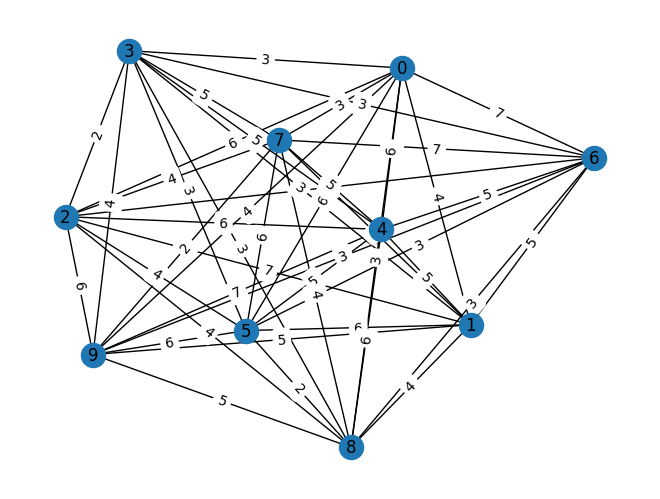

In [63]:
# Assuming create_distance_matrix returns a tuple, and you want the first element (a numpy matrix)
def create_distance_matrix(n):
    """
        You can use this function to create a distance matrix for a graph with n nodes. This should be helpful for testing your TSP implementation.
    """
    np.random.seed(0)
    matrix = np.random.randint(1, 10, size=(n, n))
    matrix = (matrix + matrix.T) // 2  # Make the matrix symmetric to represent undirected graph distances
    np.fill_diagonal(matrix, 0)  # Zero diagonal (distance from a node to itself)
    return matrix, None

# Create a distance matrix with 10 nodes
ten_nodes = create_distance_matrix(10)[0]

# Create a graph from the numpy array
G = nx.from_numpy_array(ten_nodes)

# Define positions for nodes using spring layout
pos = nx.spring_layout(G)

# Draw the graph
nx.draw(G, pos, with_labels=True)

# Add edge labels (weights)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

# Show the plot
plt.show()